In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

C:\Users\Ryan Jewik\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\Ryan Jewik\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [27]:
df = pd.read_csv('../final/o-kids-math-games.csv')

In [21]:
df

,date,review,rating,isEdited,userName,title,developerResponse,Name,IOS
0,2023-10-26 19:07:49,"First, I’m willing to change my review here, h...",1,False,Rhudy26,Delete “our story”,NaN,abc-kids-tracing-phonics,1
1,2020-02-22 18:05:15,I’m pretty picky when it comes to screen time ...,5,False,LinzATP,Fantastic app for kids,NaN,abc-kids-tracing-phonics,1
2,2021-07-01 02:53:36,To the Developers: thank you for putting your ...,5,False,Cojoe44,Amazing Apps,NaN,abc-kids-tracing-phonics,1
3,2023-08-30 23:09:09,I especially like that this FREE app teaches k...,5,False,Celmoe,Great app! Teacher approved!,NaN,abc-kids-tracing-phonics,1
4,2020-04-22 15:54:00,This app is so amazing! I was teaching my 3 ye...,5,False,User987456,AMAZING,NaN,abc-kids-tracing-phonics,1
...,...,...,...,...,...,...,...,...,...
181,2024-10-19 21:56:17,Gyaaaaaaaaaaaat,5,False,Ieatbutsss,Tgtg,NaN,abc-kids-tracing-phonics,1
182,2021-11-20 17:52:12,I can’t believe it’s without ads! My baby has ...,5,False,Happy w/the app,Great app,NaN,abc-kids-tracing-phonics,1
183,2020-11-20 20:53:08,Fzgxg was a nice help and help me out and help...,5,False,thesage.com,Title is! By e!!!,NaN,abc-kids-tracing-phonics,1
184,2020-02-12 03:52:09,This app is a sneaky way for the company to ma...,1,False,ElyasMachera,Links to External apps,NaN,abc-kids-tracing-phonics,1


In [54]:
from transformers import pipeline
classifier = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions", top_k=None)

In [39]:
def analyze_app_emotions(reviews, app_name):
    emotions_df = pd.DataFrame()
    skipped_count = 0
    
    for review in reviews:
        try:
            # Get emotions for current review
            emotions = classifier(review)
            
            # Create dictionary mapping labels to scores
            row_data = {'review': review, 'Name': app_name}
            for emotion in emotions[0]:
                row_data[emotion['label']] = emotion['score']
                
            # Convert to DataFrame row and concatenate
            review_df = pd.DataFrame([row_data])
            emotions_df = pd.concat([emotions_df, review_df], ignore_index=True)
            
        except RuntimeError as e:
            skipped_count += 1
            continue
    
    return emotions_df

In [55]:
emotion_df = analyze_app_emotions(df['review'], df['Name'].iloc[0])

In [56]:
emotion_df.shape

(8, 30)

In [61]:
emotion_df.iloc[6]['review']

'ethan gay roger 13550 ethan is 4 years old and\nmommy is 45 years old and\ndaddy is 61 years old and\nellie is 7 years old'

In [58]:
emotion_df.columns

Index(['review', 'Name', 'gratitude', 'admiration', 'love', 'joy', 'approval',
       'excitement', 'optimism', 'caring', 'pride', 'realization', 'relief',
       'neutral', 'desire', 'annoyance', 'sadness', 'disapproval', 'anger',
       'confusion', 'surprise', 'disappointment', 'remorse', 'amusement',
       'curiosity', 'disgust', 'grief', 'fear', 'embarrassment',
       'nervousness'],
      dtype='object')

In [42]:
#functions
def create_emotion_spider(emotions_df, title_suffix, color, figsize):
    # Create buffer to store image
    from io import BytesIO
    import base64
    
    # Create figure and plot
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    
    # Calculate means and get top 6
    emotion_means = emotions_df.drop(['review', 'Name'], axis=1).mean()
    top_emotions = dict(sorted(emotion_means.items(), key=lambda x: x[1], reverse=True)[:6])
    
    # Prepare data
    emotions = [emotion.capitalize() for emotion in top_emotions.keys()]
    values = list(top_emotions.values())
    
    # Setup angles
    num_vars = len(emotions)
    angles = [n / float(num_vars) * 2 * np.pi for n in range(num_vars)]
    angles += angles[:1]
    values += values[:1]
    
    # Plot data
    ax.plot(angles, values, 'o-', linewidth=2, color=color, label='Top 6 Emotions')
    ax.fill(angles, values, alpha=0.25, color=color)
    
    # Customize chart
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(emotions, size=10)
    ax.set_rgrids([0.1, 0.2, 0.3, 0.4, 0.5])
    
    plt.title(f"Emotional Analysis: {title_suffix}", size=15, y=1.05)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.tight_layout()
    
    # Save plot to buffer
    buffer = BytesIO()
    plt.savefig(buffer, format='png', bbox_inches='tight')
    buffer.seek(0)
    image_png = buffer.getvalue()
    graph = base64.b64encode(image_png).decode('utf-8')
    buffer.close()
    plt.show()
    # Clear the current figure
    plt.close()
    
    # Encode
    
    
    return graph

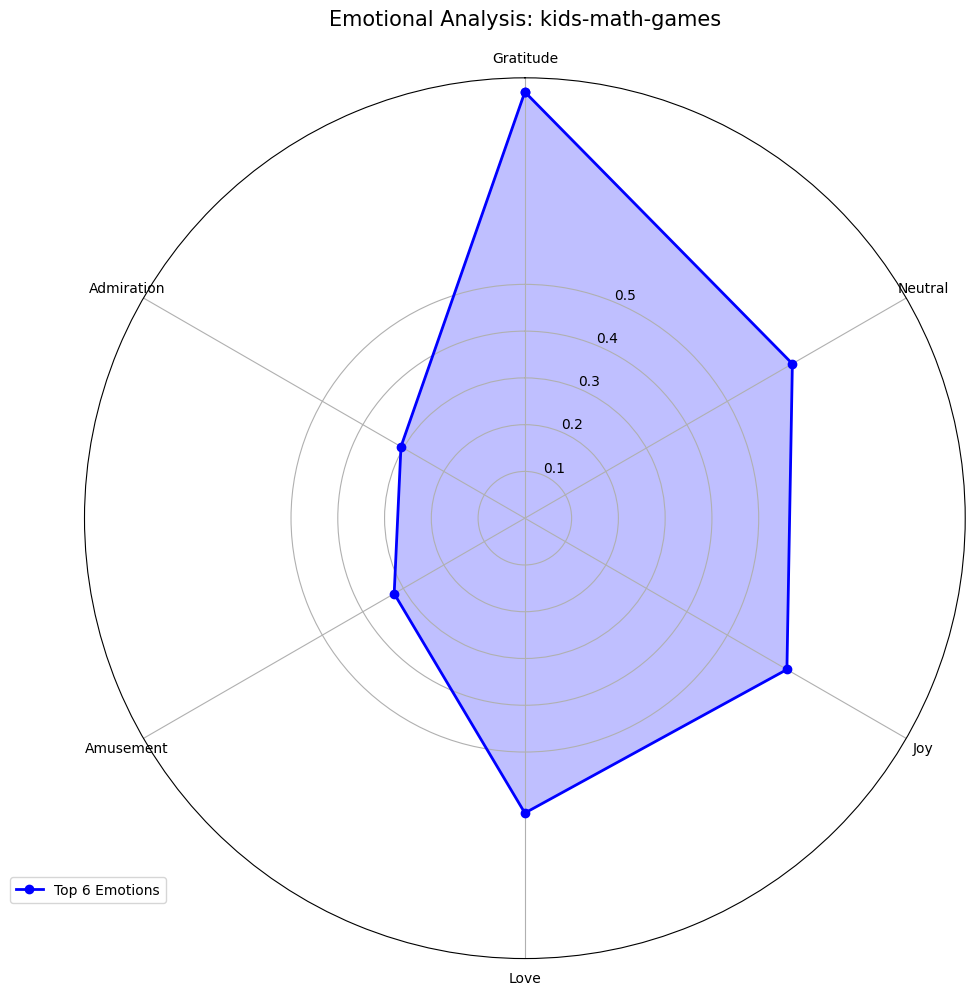

In [43]:
# Generate graph
img = create_emotion_spider(emotion_df, df['Name'].iloc[0], 'blue', (10, 10))